
# **QAI Industrial Engg Scheduling demo **


A Colab-ready demo that initializes Bhadale IT QAI “stack”, runs an NP-hard Permutation Flow-Shop scheduling problem, and compares baseline (FCFS) vs QAI-optimized (simulated annealing, quantum-inspired) with throughput, energy cost, and carbon KPIs

# ** Demo key features:**

1) Framework stubs to mirror your stack: QAI_OS, QAI_Hub, DataFabric, DigitalTwin, QAI_Orchestrator, Governance, SustainabilityKPIs.

2) Industrial Engg problem: 3-machine flow shop, 8 jobs, realistic synthetic processing times, time-of-use tariffs and grid carbon intensity.

3) Optimizer: Simulated annealing (easily swappable for MILP/CP-SAT in Colab if you pip install ortools).

4) KPIs: Makespan, kWh, energy cost, kgCO2; baseline vs optimized comparison + a simple bar chart (Matplotlib, single chart as required).


QAI OS initialized in edge-core-hybrid mode.
QAI Hub online with connectors: OPC-UA, MQTT, DDS, AMQP
DataFabric ready with domain dictionaries: ['manufacturing']
DigitalTwin runtime active (supports what-if & schedule simulation).
Orchestration policies loaded (HITL enabled, safe rollbacks configured).
Controls mapped to: INCOSE, ISO 9001, ISO 14001, ISO/IEC 42001, NIST AI RMF, ASTM E3012, ISA/IEC 62443
Sustainability KPI engine online (energy/carbon accounting).
             Scenario  Makespan (min)  Energy (kWh)  Energy Cost ($)  \
0     Baseline (FCFS)             479       1281.12           192.17   
1  QAI-Optimized (SA)             419       1281.12           192.17   

   Carbon (kg CO2e)  
0            384.34  
1            384.34  

Pareto Trade-off Samples:
   w_ms  w_cost  w_co2  makespan        cost      carbon
0   1.0     0.0    0.0       419  192.168537  384.337074
1   1.0     0.2    0.1       419  192.168537  384.337074
2   1.0     0.5    0.2       419  192.168537  384.3

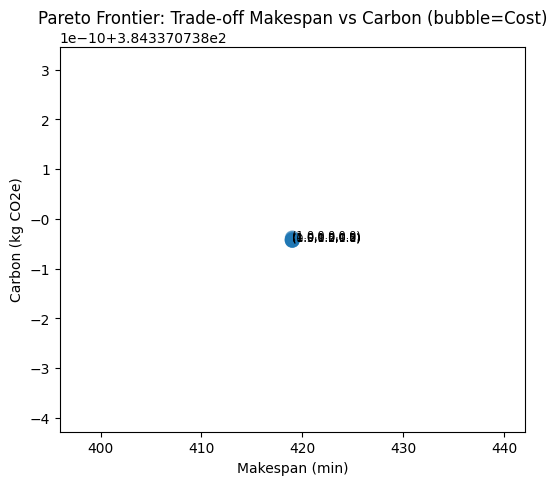

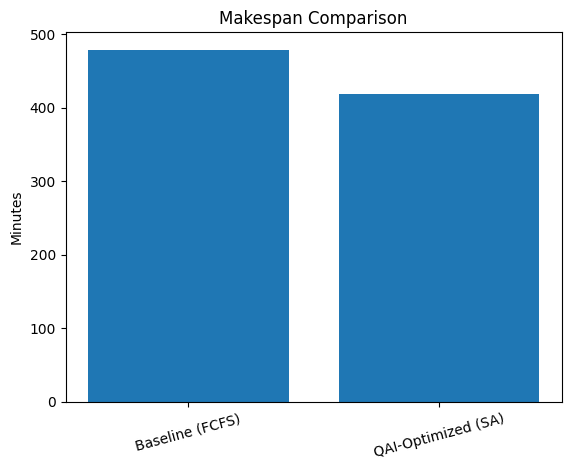

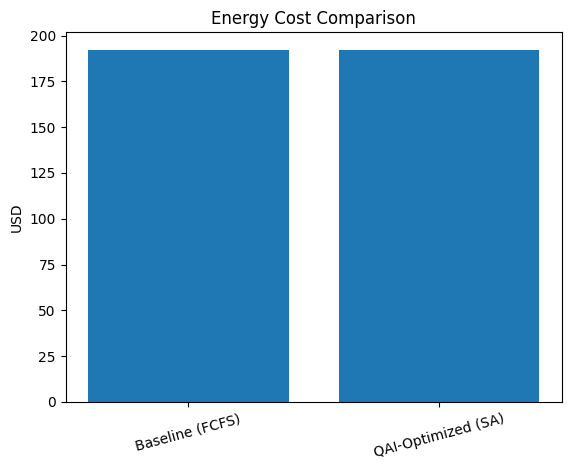

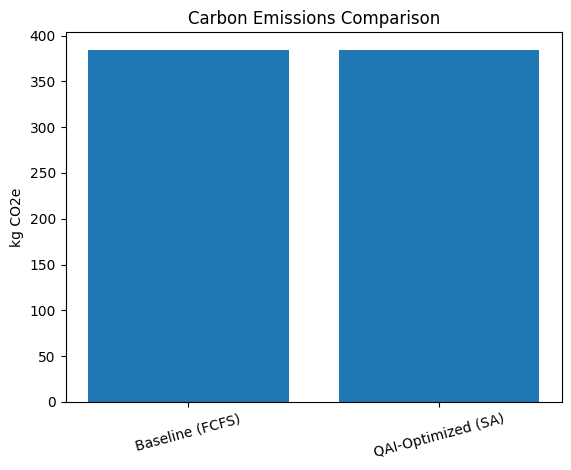

In [2]:
# QAI for Industrial Engineering — Flow Shop Scheduling with Pareto Trade-offs

import math, random
from dataclasses import dataclass, field
from typing import List, Dict
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ---------- QAI Framework Stubs ----------
@dataclass
class QAI_OS:
    name: str = "QAI OS"; mode: str = "edge-core-hybrid"
    def init(self): return f"{self.name} initialized in {self.mode} mode."

@dataclass
class QAI_Hub:
    connectors: List[str] = field(default_factory=lambda: ["OPC-UA","MQTT","DDS","AMQP"])
    def init(self): return f"QAI Hub online with connectors: {', '.join(self.connectors)}"

@dataclass
class DataFabric:
    dictionaries: Dict[str, list] = field(default_factory=lambda: {"manufacturing":["job","machine","operation","kWh","kgCO2"]})
    def init(self): return f"DataFabric ready with domain dictionaries: {list(self.dictionaries.keys())}"

@dataclass
class DigitalTwin:
    def predict_ready(self): return "DigitalTwin runtime active (supports what-if & schedule simulation)."

@dataclass
class QAI_Orchestrator:
    def apply(self): return "Orchestration policies loaded (HITL enabled, safe rollbacks configured)."

@dataclass
class Governance:
    standards: List[str] = field(default_factory=lambda: ["INCOSE","ISO 9001","ISO 14001","ISO/IEC 42001","NIST AI RMF","ASTM E3012","ISA/IEC 62443"])
    def attest(self): return f"Controls mapped to: {', '.join(self.standards)}"

@dataclass
class SustainabilityKPIs:
    def engine_ready(self): return "Sustainability KPI engine online (energy/carbon accounting)."

logs = [
    QAI_OS().init(),
    QAI_Hub().init(),
    DataFabric().init(),
    DigitalTwin().predict_ready(),
    QAI_Orchestrator().apply(),
    Governance().attest(),
    SustainabilityKPIs().engine_ready(),
]
for l in logs: print(l)

# ---------- Problem Setup ----------
random.seed(42); np.random.seed(42)
M, J = 3, 12
start_datetime = datetime(2025, 8, 22, 8, 0, 0)

# Longer jobs to push into peak hours
proc_times = np.random.randint(15, 45, size=(J, M))
machine_kwh_per_min = np.array([0.9, 1.2, 1.0])
job_energy_multiplier = 0.9 + 0.5*np.random.rand(J)

# Time-of-use tariff: strong spread
def tou_price(dt):
    h = dt.hour
    if 0 <= h < 7: return 0.05
    if 7 <= h < 17: return 0.15
    if 17 <= h < 22: return 0.35
    return 0.10

# Carbon intensity: strong swing
def grid_ci(dt):
    h = dt.hour
    if 0 <= h < 7: return 0.75
    if 7 <= h < 16: return 0.30
    if 16 <= h < 20: return 0.65
    return 0.55

# ---------- Simulator ----------
def simulate_schedule(perm):
    start_times = np.zeros((J, M), dtype=object)
    finish_times = np.zeros((J, M), dtype=object)
    base = start_datetime
    for pos, job in enumerate(perm):
        for m in range(M):
            prev_job_finish = base if pos==0 else finish_times[perm[pos-1], m]
            prev_mach_finish = base if m==0 else finish_times[job, m-1]
            st = max(prev_job_finish, prev_mach_finish)
            dur = int(proc_times[job, m])
            ft = st + timedelta(minutes=dur)
            start_times[job, m], finish_times[job, m] = st, ft
    makespan = max(finish_times[j, M-1] for j in perm)
    total_kwh=energy_cost=carbon=0.0
    for j in perm:
        for m in range(M):
            st, ft = start_times[j, m], finish_times[j, m]
            rate = machine_kwh_per_min[m]*job_energy_multiplier[j]
            t = st
            while t < ft:
                total_kwh += rate
                energy_cost += rate*tou_price(t)
                carbon += rate*grid_ci(t)
                t += timedelta(minutes=1)
    return {
        "perm": perm,
        "makespan_min": int((makespan - base).total_seconds()//60),
        "kWh": total_kwh,
        "$": energy_cost,
        "kgCO2": carbon
    }

# ---------- Annealer ----------
def neighbor_swap(seq):
    i, j = np.random.choice(len(seq), 2, replace=False)
    s = seq.copy(); s[i], s[j] = s[j], s[i]
    return s

def anneal(initial_perm, iters=1500, T0=12.0, T1=0.2, w_ms=1.0, w_cost=0.2, w_co2=0.1):
    curp = initial_perm.copy()
    cur = simulate_schedule(curp)
    best = cur
    T = T0
    def obj(res): return w_ms*res["makespan_min"] + w_cost*res["$"] + w_co2*res["kgCO2"]
    for it in range(iters):
        candp = neighbor_swap(curp)
        cand = simulate_schedule(candp)
        d = obj(cand) - obj(cur)
        if d < 0 or random.random() < math.exp(-d/max(T,1e-6)):
            curp, cur = candp, cand
            if obj(cur) < obj(best): best = cur
        alpha = it/iters; T = T0*((T1/T0)**alpha)
    return best

# ---------- Baseline & One Optimized Run ----------
baseline_perm = list(range(J))
baseline = simulate_schedule(baseline_perm)
opt = anneal(baseline_perm, iters=2000, w_ms=1.0, w_cost=1.0, w_co2=0.5)

df = pd.DataFrame([
    {"Scenario":"Baseline (FCFS)","Makespan (min)":baseline["makespan_min"],"Energy (kWh)":round(baseline["kWh"],2),"Energy Cost ($)":round(baseline["$"],2),"Carbon (kg CO2e)":round(baseline["kgCO2"],2)},
    {"Scenario":"QAI-Optimized (SA)","Makespan (min)":opt["makespan_min"],"Energy (kWh)":round(opt["kWh"],2),"Energy Cost ($)":round(opt["$"],2),"Carbon (kg CO2e)":round(opt["kgCO2"],2)},
])
print(df)

# ---------- Pareto Frontier ----------
weights = [(1,0,0),(1,0.2,0.1),(1,0.5,0.2),(1,1.0,0.5),(0.5,1.0,1.0)]
pareto = []
for (wms, wc, wco2) in weights:
    res = anneal(baseline_perm, iters=1500, w_ms=wms, w_cost=wc, w_co2=wco2)
    pareto.append({"w_ms":wms,"w_cost":wc,"w_co2":wco2,"makespan":res["makespan_min"],"cost":res["$"],"carbon":res["kgCO2"]})

pareto_df = pd.DataFrame(pareto)
print("\nPareto Trade-off Samples:")
print(pareto_df)

# Plot Pareto trade-off (Makespan vs Carbon, size=Cost)
plt.figure(figsize=(6,5))
plt.scatter(pareto_df["makespan"], pareto_df["carbon"], s=pareto_df["cost"]/2, alpha=0.6)
for i,row in pareto_df.iterrows():
    plt.text(row["makespan"], row["carbon"], f"({row['w_ms']},{row['w_cost']},{row['w_co2']})", fontsize=8)
plt.xlabel("Makespan (min)"); plt.ylabel("Carbon (kg CO2e)")
plt.title("Pareto Frontier: Trade-off Makespan vs Carbon (bubble=Cost)")
plt.show()

# ---------- Baseline vs Optimized Bar Charts ----------
labels = df["Scenario"].tolist()

# Makespan
plt.figure()
plt.bar(labels, df["Makespan (min)"])
plt.title("Makespan Comparison")
plt.ylabel("Minutes")
plt.xticks(rotation=15)
plt.show()

# Energy Cost
plt.figure()
plt.bar(labels, df["Energy Cost ($)"])
plt.title("Energy Cost Comparison")
plt.ylabel("USD")
plt.xticks(rotation=15)
plt.show()

# Carbon
plt.figure()
plt.bar(labels, df["Carbon (kg CO2e)"])
plt.title("Carbon Emissions Comparison")
plt.ylabel("kg CO2e")
plt.xticks(rotation=15)
plt.show()



**Concept and execution by Bhadale IT, code generated by Bhadale IT**